In [1]:
import re
import nltk
import emoji
import string
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from nltk.util import ngrams
import matplotlib.pyplot as plt
from transformers import pipeline
from wordcloud import STOPWORDS
from wordcloud.wordcloud import WordCloud
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
rcParams['figure.figsize'] = (15, 10)
sns.set(font_scale=1.5)

In [3]:
com_df = pd.read_csv('../data/comments_info.csv')
tweet_df = pd.read_csv('../data/tweets_info.csv')

cols_to_datetime = ['tweet_created', 'account_created']
df = pd.concat([tweet_df, com_df], axis=0, ignore_index=True)

### Text Exploration

In [4]:
df.head()

,tweet_created,conversation_id,tweet_id,author_id,text,retweet_count,reply_count,like_count,quote_count,account_created,account_id,name,verified,follower_count,following_count,tweet_count,listed_count
0,2022-06-09T23:23:33.000Z,1535039928752537618,1535039928752537618,361289499,"There's less than 100,000 blocks until the nex...",423,247,2652,13,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757
1,2022-06-09T22:18:54.000Z,1534926244369817601,1535023660301398016,361289499,Looking for #Bitcoin gear? We've got you cover...,30,34,133,2,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757
2,2022-06-09T21:04:36.000Z,1534953242878259202,1535004962417037312,361289499,Stay up to date on the latest #Bitcoin news wi...,26,28,86,1,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757
3,2022-06-09T20:28:23.000Z,1534995848278466565,1534995848278466565,361289499,"RT @mcshane_writes: In mathematics, the pigeon...",47,0,0,0,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757
4,2022-06-09T20:16:55.000Z,1534992962425192448,1534992962425192448,361289499,RT @BitcoinMagazine: @saylor @MicroStrategy Th...,44,0,0,0,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33866 entries, 0 to 33865
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_created    33866 non-null  object
 1   conversation_id  33866 non-null  int64 
 2   tweet_id         33866 non-null  int64 
 3   author_id        33866 non-null  int64 
 4   text             33866 non-null  object
 5   retweet_count    33866 non-null  int64 
 6   reply_count      33866 non-null  int64 
 7   like_count       33866 non-null  int64 
 8   quote_count      33866 non-null  int64 
 9   account_created  33866 non-null  object
 10  account_id       33866 non-null  int64 
 11  name             33865 non-null  object
 12  verified         33866 non-null  bool  
 13  follower_count   33866 non-null  int64 
 14  following_count  33866 non-null  int64 
 15  tweet_count      33866 non-null  int64 
 16  listed_count     33866 non-null  int64 
dtypes: bool(1), int64(12), object(4

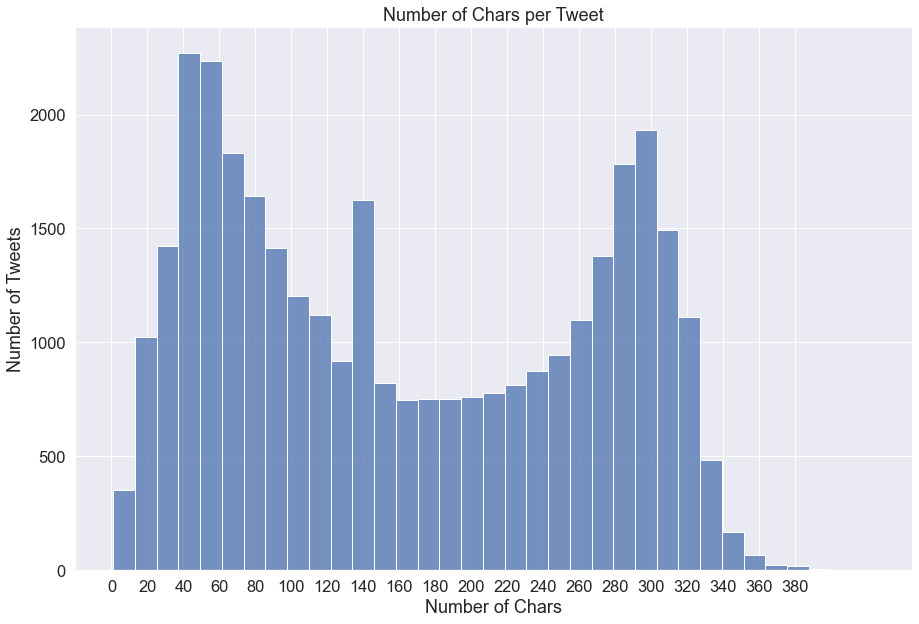

In [6]:
# let's look at the number of characters per tweet
sns.histplot(df['text'].str.len())
plt.xticks(list(range(0, 400, 20)))
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Twitter allows max 280 characters per tweets, so all the tweets with more than 280 char must contain either a lot of mentions (@someone) or links. We can also observe large amount of tweets with low number of chars. This might be caused either by stopwords, slang or something else, they might not hold a lot of meaning.
##### TODO
1. Remove Mentions (e.g. @coinbase)
2. Remove leading RT (stands for retweeted)
3. Remove leading hashtag sign
4. Remove spaces etc
5. Remove all chars but ascii and emoji

In [7]:
# let's look at the actual test and see what makes tweets surpass 280 mark
df[df['text'].str.len() > 320].text.values[1]

"@IndiraKempis @senadomexicano Subscribe to Bitcoin Magazine's FREE daily newsletter and get the latest news delivered right to your inbox!\n\nToday's edition covered:\n🏡 Home mining experts talk strategy\n🏛️ Fort Worth, TX vote on bitcoin mining bill\n🐒 Costa Rica's bitcoin jungle\n\n👇📰\nhttps://t.co/XpRwZUa1it https://t.co/VTpKm1LcaY"

In [8]:
good_chars = string.printable +  ''.join(emoji.EMOJI_DATA.keys())

In [9]:
# let's remove mentions, so we can see the actual text of the tweet, and look at the graph again
df['text'].replace(r"@[^\s]+", '', regex=True, inplace=True)  # removing mentions @
df['text'].replace(r'RT ', '', regex=True, inplace=True) # removing RT (retweeted)
df['text'].replace(r'#', '', regex=True, inplace=True)  # remove hashtags
df['text'].replace(r'http\S+', '', regex=True, inplace=True)  # removing links
df['text'].replace(r'&[A-Za-z0-9#]+;', '', regex=True, inplace=True) # removing html character reference
df.text.replace({fr'[^{good_chars}]':' '}, regex=True, inplace=True) # removing all but ascii and emojis
df['text'].replace('|'.join(string.whitespace), ' ', regex=True, inplace=True)  # remove all the whitespace chars
df['text'].replace(r'\s+', ' ', regex=True, inplace=True)  # strip extra spaces

In [10]:
df.text.sample(10)

32144     As per my most recent and continuous messagin...
3967     While there is a need for legislation that pro...
13761     Trade BTC with the best exchange platform and...
3739     It s stunning to see crypto hold up better tha...
1741      Bitcoin $BTC continues to trade around a midp...
28246     I wish Oleary would go away and take Musky wi...
180       "There is bitcoin, the absolutely scarce mone...
1915     Round One of the DESKCreator Challenge is open...
20754     Get in before and their NFTs blasts to the mo...
28114                             This will be amazing 🔥🔥🔥
Name: text, dtype: object

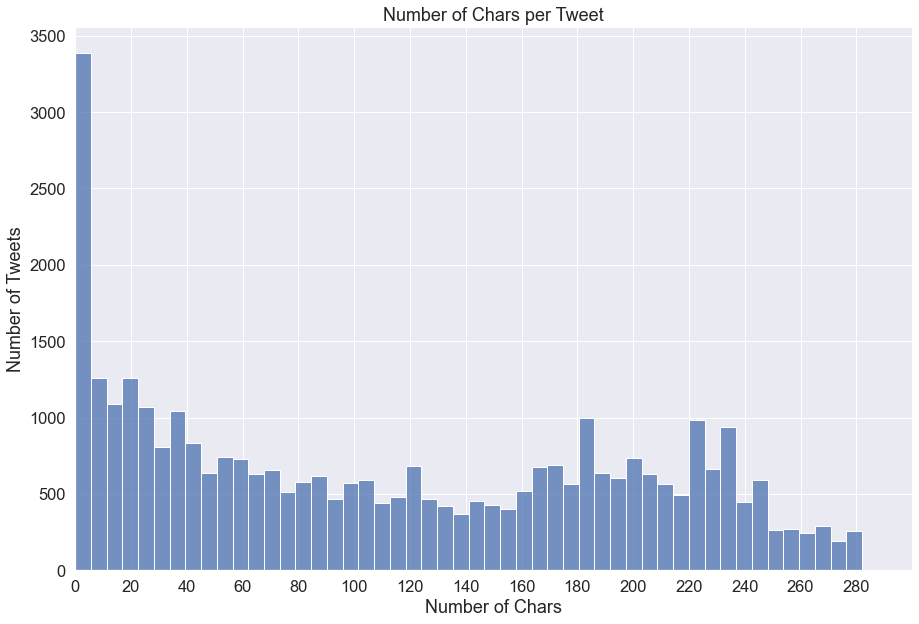

In [11]:
sns.histplot(df['text'].str.len(), bins=50)
plt.xticks(list(range(0, 290, 20)))
plt.xlim(0, 300)
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Now we see that all the tweets fall within the limit of 280 chars, but the number of tweets with less than 20 chars has increased drastically.

In [12]:
# let's see what we can fit in within 20 chars
sample_text = 'Market is going to crash'
print(f'Length of this text "{sample_text}" is {len(sample_text)} chars.')

Length of this text "Market is going to crash" is 24 chars.


###### I would think that tweets that have less than 15-20 chars are meaningless. Let's explore what kind of tweets have a few characters

In [13]:
# first let's check if we have empty strings and get rid of them
print('Number of empty string',len(df[df['text'].isin(['', ' '])].text))
df = df[~df['text'].isin(['', ' '])]

Number of empty string 2046


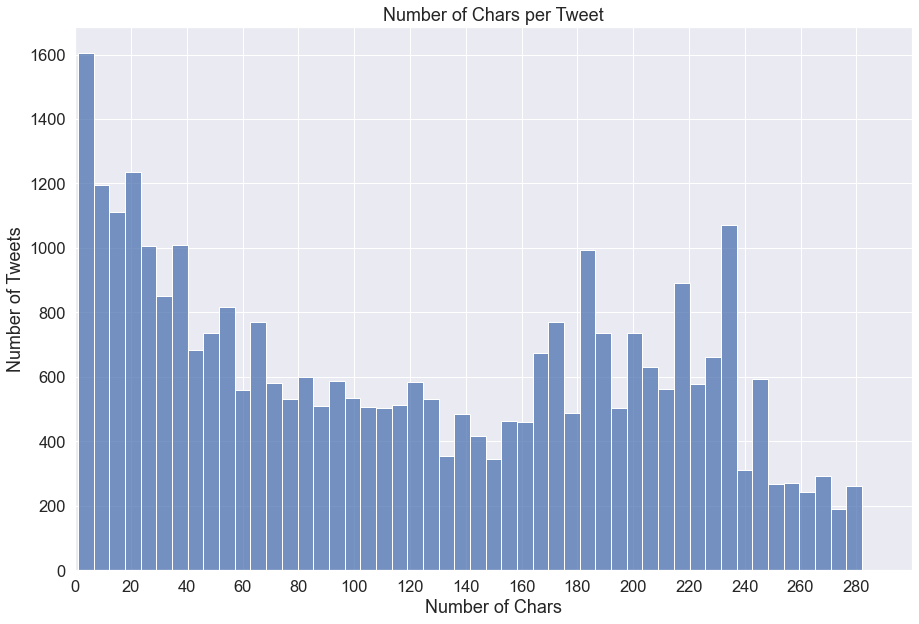

In [14]:
sns.histplot(df['text'].str.len(), bins=50)
plt.xticks(list(range(0, 290, 20)))
plt.xlim(0, 300)
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Great, we cut the number of tweets with less than 20 by a third. Although, we have to keep in mind that a lot of tweets that we get are meaningless, and we might have to extract more information. Let's continue to explore tweets with low number of words.

In [15]:
df[df.text.str.len() < 20].text.value_counts().head(40)

 gm                    129
 Thank me later        102
 Gm                     97
 👇                      73
 😂                      30
 👀                      26
 Join the chat💬👇        23
 ❤️                     22
 GM                     20
 Bitcoin $paw           18
 TRX TRON USDD          16
 Web 3                  16
 Worth reading $paw     16
 Join 💬chat to earn     16
 😂😂😂                    15
 Gm!                    14
 Gm gm                  14
 Good                   13
 gm                     13
 Gm ser                 12
 🤣🤣🤣                    10
 Slot hNFT NFT ENS      10
 Bitcoin                10
 gm!                     9
 lol                     9
 Yes                     9
 TRV Blockchain          9
 Lol                     9
 $PAW                    9
 Great                   8
 🤌🏻                      8
 🔥🔥🔥                     8
 😍                       8
 Awesome                 8
 Its real                7
 Thank you so much       7
 🤣                       7
 

###### We can observe that greeting (gm) is quite common in bitcoin community, but to us, it does not hold much value, so let's get rid of it. As well as 'Thank me later'

In [16]:
print(f"gm/thank me later like occurrences where char len is less than 20: {df[(df.text.str.contains(r'gm|Gm|GM|Thank me later', regex=True)) & (df.text.str.len() < 20)].__len__()}")
df = df[~((df.text.str.contains(r'gm|Gm|GM|Thank me later', regex=True)) & (df.text.str.len() < 20))]

gm/thank me later like occurrences where char len is less than 20: 796


In [17]:
print(f'# commments < 20 chars {df[df.text.str.len() < 20].text.shape}')
print(f'total comments {df.text.shape}')
df[df.text.str.len() < 20].text.value_counts().head()

# commments < 20 chars (3549,)
total comments (31024,)


 👇                   73
 😂                   30
 👀                   26
 Join the chat💬👇     23
 ❤️                  22
Name: text, dtype: int64

###### We see that we still have over 3k comments shorter than 20 chars, which makes it roughly 100 comments per 1000 comments or every 10th
##### TODO
1. Convert emojis to text
2.  Get rid of spam comments
3. Think how to assign meaning to one word emotions
4. We yet have not dealt with special characters

In [18]:
# let's convert emojis to words

In [19]:
# let's look at all the tweets that have emojis
emoji_df = df[df.text.str.contains(r'|'.join(map(re.escape, list(emoji.EMOJI_DATA.keys()))), regex=True)]

In [20]:
emoji_df.text.sample(10)

11635                                                    👇
17887     BTC DeFi LUFFY LuffyToken ETH 💥5 dapps are bu...
16057     🚨IDO ALERT🚨 is pleased to announce the IDO of...
5658                         I bet many just don't wash 🤣🤣
17632     🌎 Muuu World 🌎 Original muu inu support this ...
18547     📢 Products will be on sale at a great price w...
935      NEW 💥 Telegram app users can now buy bitcoin u...
16868     I hope you have heard about already! $GYRO is...
21709     🪐 WELCOME TO BEERUSX100 🔥 ✅ KYC Audit ✅ No te...
25449     Oracle is ASaaS Protocol combine with Auto Co...
Name: text, dtype: object

In [21]:
# let's demojize these tweets and see what is does
demojized_df = emoji_df.copy(deep=True)
demojized_df.loc[:, 'text'] = demojized_df.text.apply(lambda row: emoji.demojize(row))

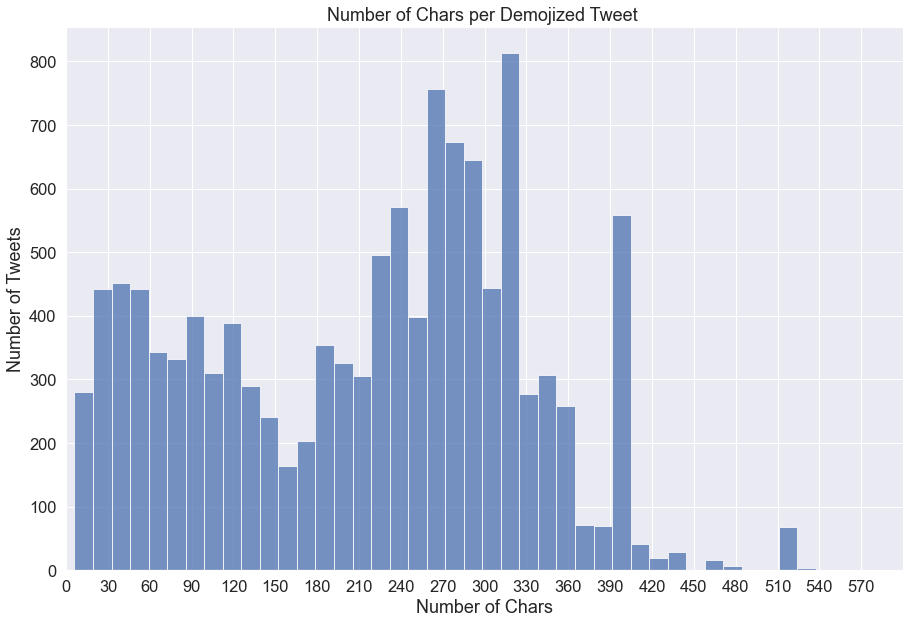

In [22]:
sns.histplot(demojized_df.text.str.len(), bins=100)
plt.xlim(0, 600)
plt.xticks(list(range(0, 600, 30)))
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Demojized Tweet ');

###### We can see how it increases number of chars per tweet, lets take a closer look at the outliers

In [23]:
# let's take a look at the tweets that exceed 300 chars (we will give a buffer of 20 chars)
emoji_outliers = demojized_df[demojized_df.text.str.len() > 300].text.map(lambda row: emoji.emojize(row))
emoji_outliers.value_counts().head(10)

 🪐 WELCOME TO BEERUSX100 🔥 ✅ KYC Audit ✅ No team tokens ✅ Liquidity will be locked after listing ✅ Ownership will be renounced ✅ Lowcap presale ✅ Tax 4% (buy/sell) 👉 Contract: 👉 ILO : 🌎                                                                503
 🚨IDO ALERT🚨 is pleased to announce the IDO of on the 15th of June at 12 PM UTC! All you need to know about is; 💎 Total tokens for sale: 600,000 EMT 💰 Total Raise: 1,200,000$ 💵 IDO Price: 0.05$ 🚀 Initial MC at TGE: 217,000$ BNB crypto               415
 💎 Introducing Bit-Luna 0.5 token, the heir to the Luna fortune - Join us for 1000x gains 💰Total Supply: 10,000,000,000 💊 9% BUY / 15% SELL TAX 💊 SAFU: LIQUIDITY LOCKED 100% 💊 AUDIT + KYC 💊 WHITEPAPER 💊 VERIFIED CONTRACT 💊 RARE NFTS 📌 Telegram:     116
 ✅ World First USE -2- EARN Ecosystem. ✅ 🚀 Alpha App Live 📲 No Private Sale 📲 Contract Verified 📲 Audit By ContractWolf 📲 KYC'd By Doxxed 📲 Partnership With Coinhunt,NABOX, IKONIC, parrot bamboo                                               

In [24]:
df.text.value_counts().head(10)

 🪐 WELCOME TO BEERUSX100 🔥 ✅ KYC Audit ✅ No team tokens ✅ Liquidity will be locked after listing ✅ Ownership will be renounced ✅ Lowcap presale ✅ Tax 4% (buy/sell) 👉 Contract: 👉 ILO : 🌎                                                                                       503
 🚨IDO ALERT🚨 is pleased to announce the IDO of on the 15th of June at 12 PM UTC! All you need to know about is; 💎 Total tokens for sale: 600,000 EMT 💰 Total Raise: 1,200,000$ 💵 IDO Price: 0.05$ 🚀 Initial MC at TGE: 217,000$ BNB crypto                                      415
 📌🔥 CRYPTO ASSISTANT 🔥 Crypto Assistant is a platform where you can find all crypto token information in one place,clearly arranged in one agenda... Web: TG: 🟢8% buy sell tax 🟢LP locked 🟢Kyced Audited 🟢presale: 6/17/2022                                                    289
 🐕 $DOGGER 🐕 Dogger aims to be the first decentralized and open source social media platform for the crypto world ☑️ A greatly improved contract ☑️ Huge staking rewards ☑️ 

###### Wow, if we compare duplicates in main dataframe and dataframe with emojis that have too many characters, we can see that the top duplicates are identical. This signifies that most of the spam comments will be using extensive amount emojis. We should be getting rid of the extensive number of duplicate comments from the main df  (maybe over ~20 duplicates) in the beginning of preprocessing to speed up the process.
##### We should try a different thresholds, I think a good point to start is 20 duplicates, however we need to keep in mind that spam comments might influence human behaviour.

In [25]:
df.text.value_counts().describe()

count    20527.000000
mean         1.511375
std          6.165754
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        503.000000
Name: text, dtype: float64

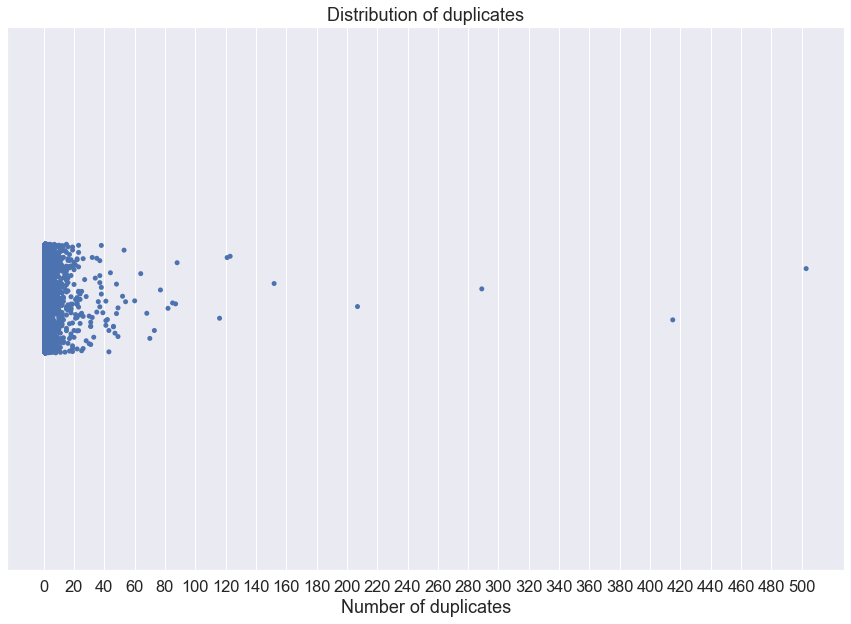

In [26]:
# let's visualize distribution of the duplicate tweets
sns.stripplot(x=df.text.value_counts().to_numpy(), )
plt.title('Distribution of duplicates')
plt.xticks(list(range(0, 520, 20)))
plt.xlabel('Number of duplicates');

In [27]:
# let's read some tweets
df.text.value_counts().reset_index(name='counts').loc[1010: 1030, :]

,index,counts
1010,🚀🚀🚀🚀,3
1011,No.,3
1012,Enjoy invest SKUY,3
1013,Nice!,3
1014,Great project cmcx core coremultichain CMCX C...,3
1015,"click the link, thank me later .",3
1016,For those who have a beating heart with relie...,3
1017,Checkout 🔥 Rocket City Metaverse upgraded ver...,3
1018,TERRA-LUNA and Do Kwon.. When will you clean ...,3
1019,"Hello guys,🥰🥰 Aex exchange has listed OP, Now...",3


###### We can see that even when there are only two duplicates, a majority of them are still spam comments. So we definitely should start with the threshold of 2 duplicates instead of 20 lol

In [28]:
# keeping only tweets that repeat no more than twice
df = df[~df['text'].isin(df['text'].value_counts().loc[lambda cnt: cnt > 2].index)]

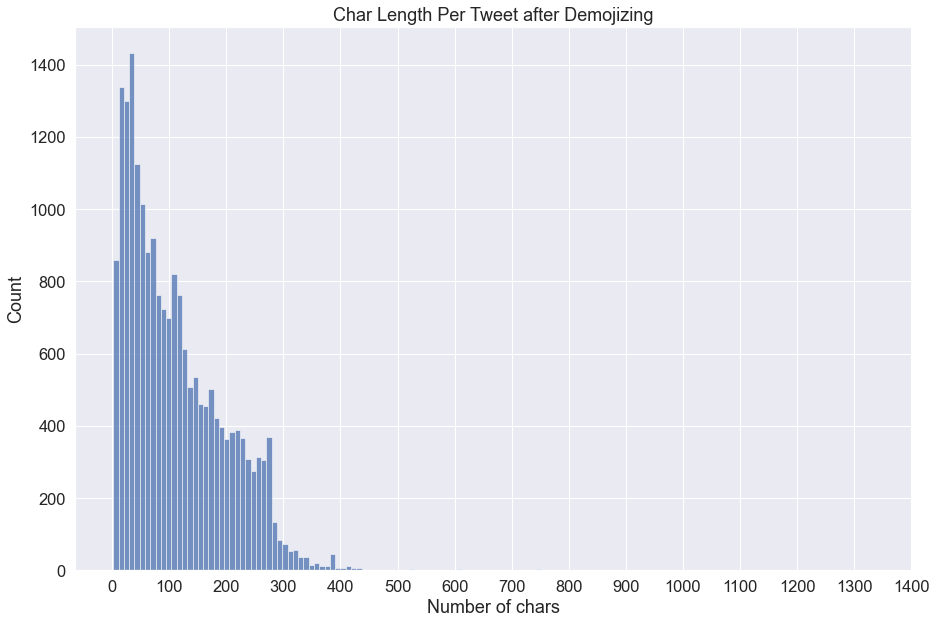

In [29]:
# now we can convert emoji to text
demojized_df = df.text.apply(lambda row: emoji.demojize(row))
sns.histplot(demojized_df.str.len())
plt.xticks(list(range(0, 1500, 100)))
plt.title('Char Length Per Tweet after Demojizing')
plt.xlabel('Number of chars');

###### we keep observing outliers after demojizing tweets, let's look into those outliers.

In [30]:
df.loc[demojized_df.str.len().sort_values(ascending=False) > 280, 'text'].sample(10)

21947     Yes. Just concentrate on BTC,XRP and ETH mini...
6753      Gm 🥰 Sure Cpos 👍 Great News for you 📣 Listing...
27906     🧪Project 🧪Token-MoonLabs $MLABS 🧪Supply-10000...
6502      🥰 Cpos 🤝 Btc 👍 Great News 📣 Listing Partnersh...
22680     🔥 PVE MODE IS COMING IN 👉 Gathering your team...
29834     Your benefit is safe and 100% back-back guara...
30187     For bitcoin I don t know, but for veGYRO for ...
16920     In 2021 there was around 106 Mil btc holders ...
11268     WSG MilkyWayDefi Play game n earn money HOLDE...
722      Sign up to get Bitcoin news delivered right to...
Name: text, dtype: object

###### we can see that even though 1-2 comments are genuine, the majority of them are spam as well. So that will be our second spam check. We will have to convert emoji to text first in this case.

In [31]:
df.loc[:, 'text'] = df['text'].apply(lambda row: emoji.demojize(row))

In [32]:
# now we will get rid of the tweets with more than 280 chars because there is a high chance of them being spam
df = df[df.text.str.len() < 280]

In [33]:
df[df.text.str.len() > 275].text.apply(lambda row: emoji.emojize(row)).sample(10)

5067      So as I said you misquoted what I Said, you s...
13059     Being big means hosting large communities. DK...
26234     I dreamed I was a burrito with all the stuff ...
22722     Hello , how are you? I present to you this be...
27859     I m super bullish on Relaunching soon✨✨ ✅Amaz...
11927     From my understanding those base load plants ...
5372      For those that don't know hotels figure out h...
21002     Same as gold. Why do we want it if it isn't t...
12311     Bitcoin investment is the beginning of someth...
21770     Hello mate💕☺️The AEX exchange has listed OP, ...
Name: text, dtype: object

###### Now if we look at some samples with the highest number of chars, most of the tweets are genuine, though some of the spams still persist

In [34]:
# for now let's convert demojized text back to emoji until we deal with low char count comments
df.loc[:, 'text'] = df['text'].apply(lambda row: emoji.emojize(row))

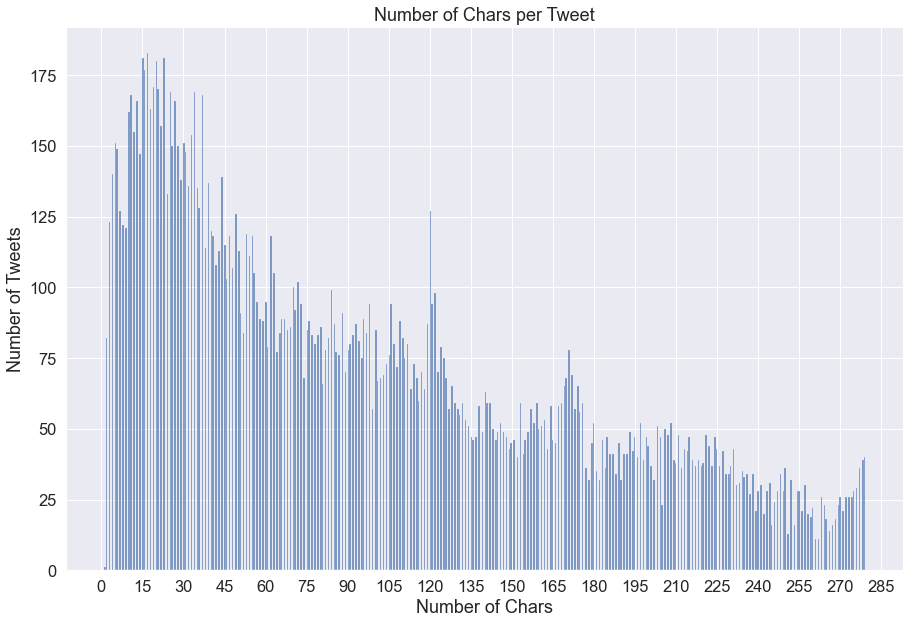

In [35]:
sns.histplot(df['text'].str.len(), bins=500)
plt.xticks(list(range(0, 295, 15)))
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### It looks like we were able to deal with some problematic long tweets, but we have not achieved as mush success with short tweets. Let's take a closer look with what kind of text we are working with.

In [36]:
short_tweets = df.loc[df[df.text.str.len() < 20].text.str.len().sort_values().index, :]
print(f'Length of short_tweets {len(short_tweets)}')
print(short_tweets.text.tolist())

Length of short_tweets 2689
['👍', ' 😘', ' \U0001faf6', ' 👑', ' 💩', ' 🐐', ' S', ' 💀', ' 🙈', ' ✅', ' \U0001fae1', ' 🎉', ' 👏', ' ☕', ' 😇', ' 🚮', ' 🧐', ' 😃', ' 😃', ' 🥂', ' 🖕', ' 💗', ' 🫂', ' 🌕', ' 🦾', ' \U0001fae3', ' 🧐', ' 1', ' 🦉', ' 😏', ' K', ' 💣', ' 🤍', ' 😅', ' Y', ' 😀', ' 🤞', ' 🤝', ' *', ' 🍿', ' 🔮', ' 😅', ' 🤢', ' ⚡', ' 🤦', ' 🙄', ' \U0001fae0', ' G', ' 🤚', ' 😇', ' 🍿', ' 👎', ' 😎', ' 👏', ' 😉', ' 💡', ' !', ' 😭', ' 😹', ' 🥱', ' 🤞', ' !', ' 🐐', ' 😵', ' 🍳', ' \U0001fae1', ' 💩', ' 2', '✊ ', ' 🙂', ' 🌙', ' 🤨', ' 5', '😂 ', ' 🤭', ' 💣', ' 🧡', ' 😹', ' 🥂', ' \U0001fae3', ' 😬', ' \U0001faf6', ' 😁', ' 91', ' 👀🦉', ' 💪👍', ' 🦉🔥', ' 🟥🟦', ' 🤔 ', ' 💎🦉', ' qq', ' 😎👍', ' 👀😎', ' 🙌🏽', ' HI', ' 👽🦉', ' 💫🦉', ' 👀😎', ' mg', ' ew', ' 🤪👈', ' 💪💪', ' ✌️', ' \U0001faac🦉', ' 🦉👀', ' 🥵🙈', ' 🦉🎱', ' 🦉💎', ' So', ' \U0001fae1🔥', ' 🦉💣', ' BT', ' 🤓🤓', ' 🤡🤣', ' 🤫 ', ' 👌🏻', ' 🤡🤡', ' 👇 ', ' ?!', ' 😀😀', ' Hi', ' :/', ' 🙂👽', ' 🥴🥴', ' 🕷️', ' 😁👌', ' 🤔🤔', ' 🔥🚀', ' 🚀 ', ' 👀🔥', ' 😥😥', ' ✌️', ' A+', ' 👀🍺', ' ? ', ' 🦉💸', ' 🎧🎶', ' 🙄🤡', ' 👍👍', '

###### We can see that most of it is useless, but as the number of chars increases, we can derive some meaning. We have the following options.
1. Remove tweets which have less than n number of chars, where n is ~ 20
2. Do a lot of regex to try match most common patterns and get rid of them
3. Extract comments that have adjectives (maybe something else) using nltk library, get rid of the rest. Without context many single adjectives might skew our average sentiment. Therefore, we can prepend the original tweet to the adjective. That way, our model will have more context and an emotion/reaction about it in the end. It could be a good guidance for classifying ambiguous original tweets.
4. Lastly, when averaging our sentiments, we can assign lower weights to comments with low number of characters.

In [37]:
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
# let's see what speech tags nltk library offers us and what we find most useful
short_tweets.text.apply(lambda row: str(nltk.pos_tag(nltk.word_tokenize(row)))).sample(20)

6251              [('HFSP', 'NNP'), ('Washington', 'NNP')]
33413    [('THIS', 'NNP'), ('IS', 'VBZ'), ('SO', 'NNP')...
22550    [('I', 'PRP'), ('made', 'VBD'), ('$', '$'), ('...
13168    [('$', '$'), ('100K', 'CD'), ('BTC', 'NNP'), (...
22120    [('You', 'PRP'), ('forgot', 'VBP'), ('a', 'DT'...
23507                                [('🔥🔥🔥🔥🔥🔥🚀🚀🚀', 'NN')]
21856    [('THATS', 'NNP'), ('MAH', 'NNP'), ('SHIT', 'N...
10204    [('Let', 'VB'), ('go', 'VB'), ('AMP', 'NNP'), ...
16510                                      [('Yep', 'NN')]
25724    [('this', 'DT'), ('is', 'VBZ'), ('awesome', 'J...
24428             [('$', '$'), ('ubt', 'JJ'), ('👀', 'NN')]
20688                         [('Yes', 'UH'), ('👍', 'NN')]
33588                      [('for', 'IN'), ('sure', 'JJ')]
26177          [('You', 'PRP'), ('too', 'RB'), ('!', '.')]
17501    [('It', 'PRP'), ('s', 'VBZ'), ('a', 'DT'), ('c...
20069                                  [('thanks', 'NNS')]
30911    [('Yeah', 'UH'), ('no', 'DT'), ('kidding', 'NN'

###### We can see that we cannot rely on nouns (NN) because most of the trash contains a noun. I think we might be interested in:
* JJ - Adjective
* RB - Adverb

In [38]:
# let's take a look at adverbs but not adjectives
print(short_tweets[short_tweets.text.apply(lambda row: str(nltk.pos_tag(nltk.word_tokenize(row)))).str.contains(r'(?!JJ)RB', regex=True)].text.values)

[' So' ' How' ' How' ' So?' ' Soon' ' why ' ' Soon' ' When?' ' Maybe'
 ' maybe' ' Soon ' ' Right' ' Why? ' ' why ?' ' Rarely' ' Indeed'
 ' Surely' ' Indeed' ' Enough' ' Me too' ' indeed' ' When ?' ' Gn here'
 ' So true' ' not now' ' Right 🙂' ' indeed ' ' so true' ' really '
 ' so dumb' ' really?' ' How not' ' exactly' ' You too' ' Exactly'
 ' So cool!' ' i m not ' ' Finally!' ' So good!' ' too slow' ' Why not?'
 ' So 2012.' ' So true!' ' be it so' ' more FUD' ' Really? ' ' You too!'
 ' Not bad.' ' Finally!' ' Not bad.' ' So true ' ' Indeed..' ' so sweet'
 ' when rug?' ' likewise!' ' So many! ' ' Very good' ' only $10🧐'
 ' ya why ?!' ' very good' ' haha why?' ' just fyi ' " We don't."
 ' very nice' ' So cool!!' ' maybe yes' ' I m here!' ' Very soon'
 ' Hopefully' ' even more' ' Exactly 🤝' ' Very nice' ' Really???'
 ' Here: 👊⚡ ' ' likewise!' ' I m here!' ' so biased' ' Just wow '
 ' Finally!!' ' Well said.' ' Very good.' ' What? Why?' ' bad indeed'
 ' Well said.' ' here it is' " They don

In [39]:
# not let's look at adjectives
print(short_tweets[short_tweets.text.apply(lambda row: str(nltk.pos_tag(nltk.word_tokenize(row)))).str.contains(r'(?!RB)JJ', regex=True)].text.values)

[' Big' ' Few.' ' Sure' ' Few.' ' GOOD' ' real' ' true' ' 🤣 🤣 🤣' ' gross'
 ' Few 👌' ' Good.' ' Good!' ' Short ' ' great.' ' great.' ' nice 😆'
 ' true 🤫' ' 👍 $PAW' ' Low...' 'great! ' ' Good 👏👏' ' Good mo' ' So true'
 ' so true' ' 🤣 😂 😆 😝' ' so dumb' ' 🐐 👑 🧑\u200d🚀' ' $ubt 👀 ' ' Lunatic'
 ' 195****' ' *thanks' ' bearish' ' Bearish' ' Bullish' ' French?'
 ' He is 🥰' ' Clean 👀' ' Bullish' ' Good one' ' So cool!' ' Oh great'
 ' for sure' ' Bullish!' ' easy win' ' So good!' ' too slow' ' Optional'
 ' lol sure' ' So true!' ' big ooof' ' short it' ' Not bad.' ' Sensible'
 ' Not bad.' ' Bullish ' ' Good new' ' Good day' ' same 👍👍👍' ' So true '
 ' Good one' ' so sweet' " I'm lost" ' Awesome!!' ' blue Chip'
 ' real btc ' ' So many! ' ' Good $paw' ' small tbh' ' Very good'
 ' blue Chip' ' Wonderful' ' 😂 🥴 0.03%' ' very good' ' Wonderful'
 ' very nice' ' So cool!!' ' fake news' ' True $paw' ' Bullish 🚀'
 ' Bullish ✅' ' Bullish 💪' ' Good news' ' Nice ! 😉🍻' ' Very nice'
 ' Hilarious' ' Eggstatic' ' 

###### It does not seem that neither of them have to many spam messages, though to me it looks like comments with adjectives are more informative. I think if we will be prepending the original tweet to them, we can keep both, because some of the noise will get neglected

In [40]:
adj_short = short_tweets[short_tweets.text.apply(lambda row: str(nltk.pos_tag(nltk.word_tokenize(row)))).str.contains(r'JJ|RB', regex=True)]
print(f'Length of comments filtered by adj|adverb is {len(adj_short)}')
print(adj_short.text.values)

Length of comments filtered by adj|adverb is 735
[' So' ' How' ' How' ' Big' ' So?' ' Few.' ' Sure' ' Few.' ' GOOD' ' real'
 ' true' ' Soon' ' why ' ' Soon' ' When?' ' Maybe' ' maybe' ' Soon '
 ' Right' ' 🤣 🤣 🤣' ' Why? ' ' why ?' ' gross' ' Few 👌' ' Good.' ' Good!'
 ' Rarely' ' Short ' ' Indeed' ' Surely' ' Indeed' ' great.' ' Enough'
 ' Me too' ' great.' ' indeed' ' nice 😆' ' true 🤫' ' 👍 $PAW' ' Low...'
 ' When ?' 'great! ' ' Good 👏👏' ' Good mo' ' Gn here' ' So true'
 ' not now' ' Right 🙂' ' indeed ' ' so true' ' really ' ' 🤣 😂 😆 😝'
 ' so dumb' ' 🐐 👑 🧑\u200d🚀' ' $ubt 👀 ' ' really?' ' Lunatic' ' 195****'
 ' *thanks' ' bearish' ' How not' ' Bearish' ' Bullish' ' exactly'
 ' French?' ' He is 🥰' ' Clean 👀' ' You too' ' Exactly' ' Bullish'
 ' Good one' ' So cool!' ' Oh great' ' for sure' ' i m not ' ' Bullish!'
 ' easy win' ' Finally!' ' So good!' ' too slow' ' Optional' ' lol sure'
 ' Why not?' ' So 2012.' ' So true!' ' be it so' ' more FUD' ' Really? '
 ' You too!' ' big ooof' ' short it

##### Great! It looks like we are able to get rid of most the garbage comments, and leave only short reactions. Let's try to prepend the original tweets to these replies and see what we get

In [41]:
adj_short = pd.merge(df[['tweet_id', 'text']], adj_short, how='right', left_on='tweet_id', right_on='conversation_id')
adj_short.drop(['tweet_id_x'], axis=1)
adj_short['prepended'] = adj_short['text_x'] + adj_short['text_y']

In [42]:
adj_short[['prepended', 'text_x', 'text_y']].sample(10)

,prepended,text_x,text_y
689,If El Salvador defaults on its $800 million so...,If El Salvador defaults on its $800 million so...,Where do we short
180,Is that what happened to your bull? 🐂 Don't miss,Is that what happened to your bull? 🐂,Don't miss
630,When is the next Bitcoin leg down coming? You...,When is the next Bitcoin leg down coming?,You guys are fags
195,JUST IN - Over 11k comments have been submitte...,JUST IN - Over 11k comments have been submitte...,don't stop
619,NaN,NaN,Much appreciated!
561,BREAKING: Jack Dorsey and Jay-Z to fund Bitcoi...,BREAKING: Jack Dorsey and Jay-Z to fund Bitcoi...,Why is pictured?
9,"Bitcoin doesn't need the US, the US needs Bitc...","Bitcoin doesn't need the US, the US needs Bitc...",real
697,"Move over, pizza. You can now buy a burrito wi...","Move over, pizza. You can now buy a burrito wi...",👀🐷 PigeInu soon!!!
572,BREAKING: PayPal users can now withdraw bitcoi...,BREAKING: PayPal users can now withdraw bitcoi...,Good news indeed
707,NaN,NaN,Good morning☕ Ser🎩


In [43]:
adj_short.prepended.isna().sum() / adj_short.__len__()

0.18231292517006803

###### Great! I think this could work, it gives more context to some of the reactions. We see that around 18% of the comments couldn't find its original tweet, so in our pipeline we will be getting rid of such as well. So this is probably would be one of the better ways to deal with short comments. Let's see how a little longer comments look like.

In [44]:
# tweets with 30 < chars < 40
df.loc[df[(df.text.str.len() > 30) & (df.text.str.len() < 40)].text.str.len().sort_values().index, 'text'].sample(10)

23722             What will Bitcoin reach first?
4567          When you re here, you re family 🤌🏻
19101        Wow just like Luna classic ? 👁️👁️👁️
21718     Check this out and thank me later❤️❤️ 
7072              Wouldn't put my money on it 🥹.
17325         Thank God they get something right
27336       Lets go Ripple's fair notice defense
20729     What would happen when dumps Bitcoin ?
5475           That s literally an AWS you moron
15550           Yup. Especialy trough Lightning.
Name: text, dtype: object

In [45]:
# comments with 40 < chars < 50
df.loc[df[(df.text.str.len() > 40) & (df.text.str.len() < 50)].text.str.len().sort_values().index, 'text'].sample(10)

26910      More 🤡 reporting from the shitcoin publication!
19627             That's was a huge achivement for Bitcoin
30914             Dm me for more information about crypto,
21030      Those big guys are betting on a losing horse. 😂
29561           Easy to grow and making sauces even easier
6784      Great! I heard their economy doing better since.
26747           Correction: $100m fine for the first part*
6514      SEC dinosaurs....and you know how they ended up!
4918        Any idea what's the good event to participate?
31242           bitcoin parece cojo por todos lados se cae
Name: text, dtype: object

###### We can see most of these comments are not spam, some of them are out of the context, but let's leave it as it is for now.

In [46]:
# now let's transform our main df and apply some changes that we just talked about
shrt_cmts = df.loc[df.text.str.len() < 20, 'text'].index.tolist()
shrt_keep = df.loc[shrt_cmts, 'text'][df.loc[shrt_cmts, 'text'].apply(lambda row: str(nltk.pos_tag(nltk.word_tokenize(row)))).str.contains(r'RB|JJ', regex=True)].index.tolist()
shrt_drop = list(set(shrt_cmts) - set(shrt_keep))

In [47]:
# creating temporary df where we will merge short comments with their parent tweet
temp_df = df.loc[shrt_keep, ['text', 'conversation_id']]
temp_df['index'] = temp_df.index
temp_df = pd.merge(df[['tweet_id', 'text']], temp_df, how='right', left_on='tweet_id', right_on='conversation_id')
temp_df['prepended'] = temp_df['text_x'] + ' ' + temp_df['text_y']

In [48]:
temp_df[['text_y', 'text_x', 'prepended', 'index']].head(10)

,text_y,text_x,prepended,index
0,Tomorrow: 🤝 🤝 🤝 🤝,Tomorrow: 🤝 🤝 🤝 🤝,Tomorrow: 🤝 🤝 🤝 🤝 Tomorrow: 🤝 🤝 🤝 🤝,83
1,I am live with on,I am live with on,I am live with on I am live with on,224
2,They never learn 🤣,They never learn 🤣,They never learn 🤣 They never learn 🤣,397
3,Stable coin,Stable coin,Stable coin Stable coin,703
4,Live with on,Live with on,Live with on Live with on,849
5,e your own ank 🙌,e your own ank 🙌,e your own ank 🙌 e your own ank 🙌,1154
6,same! Next time ❤️,NaN,NaN,4228
7,likewise!,Had an excellent time in the UK and even got t...,Had an excellent time in the UK and even got t...,4253
8,I m here!,NaN,NaN,4258
9,Love this so much,NaN,NaN,4264


In [49]:
# we can see that in some cases if the short tweet is the original comment, then it will be mapped to itself, this does not provide us any useful information, so we will drop such comments, as well as nan
to_drop = temp_df.loc[(temp_df['text_y'] == temp_df['text_x']) | (temp_df['text_x'].isna()), 'index'].values.tolist()
shrt_drop += to_drop
temp_df = temp_df.loc[~((temp_df['text_y'] == temp_df['text_x']) | (temp_df['text_x'].isna())), ['prepended','index']]

In [50]:
# we are dropping short comments that are either do not have an adjective or and adverb, do not have original comment(nan) or they are the original comment
df.drop(shrt_drop, axis=0, inplace=True)

In [51]:
# now lets change the short comments to their prepended version
df.loc[temp_df['index'], 'text'] = temp_df['prepended'].values.tolist()

In [52]:
# let's see how it worked out
df.loc[temp_df['index'], 'text'].head()

4253    Had an excellent time in the UK and even got t...
4277    Having a great time in the UK catching up with...
4662    UI / UX design is one of my favorite stages of...
4749    There's less than 100,000 blocks until the nex...
4757    There's less than 100,000 blocks until the nex...
Name: text, dtype: object

In [53]:
df.loc[df.text.str.len() < 20, 'text']

31650     Leverage.   Me too
31659    Leverage.   He is 🥰
Name: text, dtype: object

###### We see that we still have some prepended comments that are less than 20. In our pipeline we will get rid of them. Now it seems like we have dealt with extremely short and extremely long comments. Let's demojize our df once more and visualize it again.

In [54]:
df.loc[:, 'text'] = df.text.apply(lambda row: emoji.demojize(row))

In [55]:
df.loc[df.text.str.len() > 280, 'text']

4253     Had an excellent time in the UK and even got t...
15647    JUST IN: Bitcoin transactions up to $200 will ...
33163    Had an excellent time in the UK and even got t...
Name: text, dtype: object

In [56]:
df.loc[df.text.str.len() < 20, 'text']

31650    Leverage.   Me too
Name: text, dtype: object

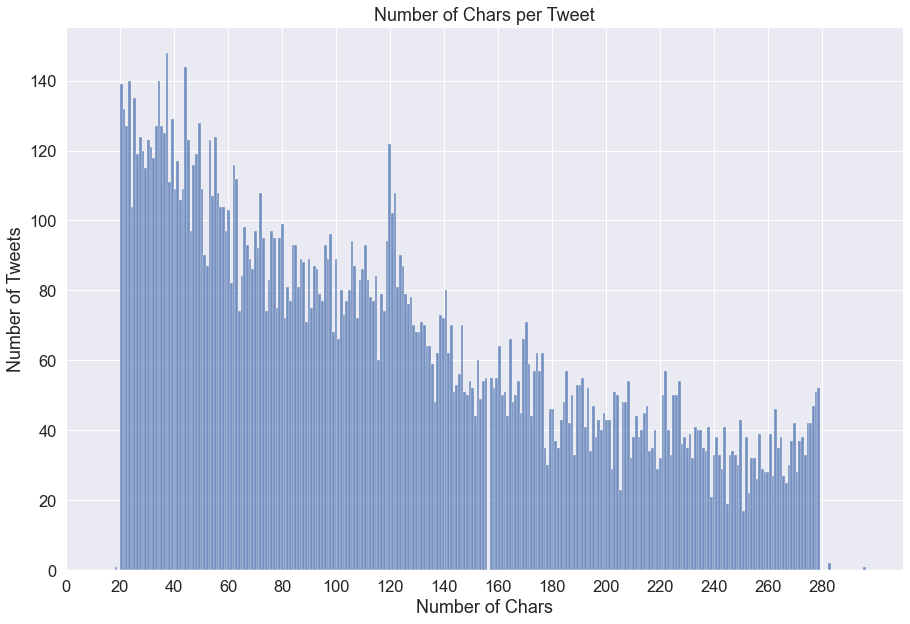

In [57]:
sns.histplot(df['text'].str.len(), bins=280)
plt.xticks(list(range(0, 290, 20)))
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Great, we can see that we practically do not have any tweets with less than 20 chars. Also, we can see that we have some tweets that exceed the 280 mark, and those are a few prepended tweets. Let's continue

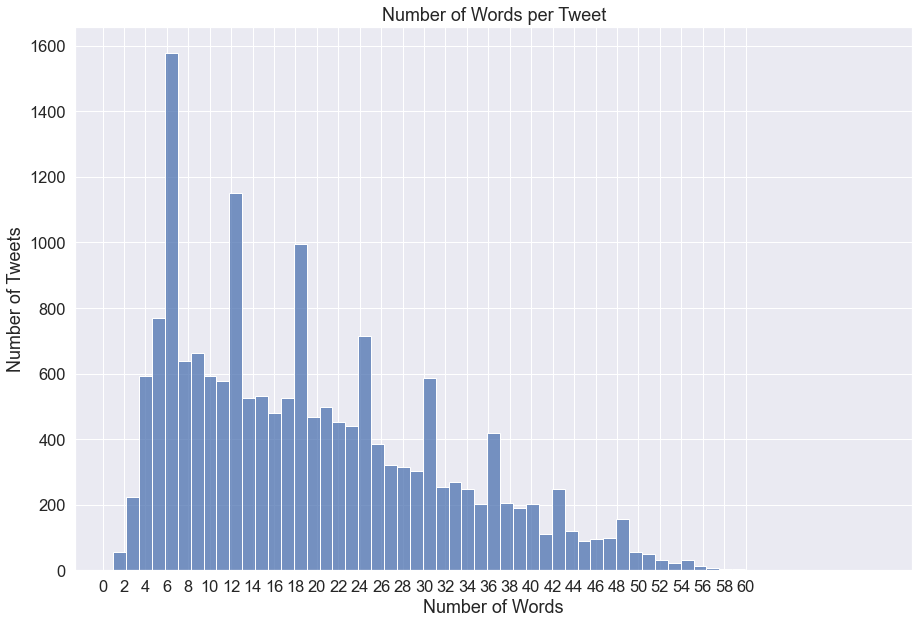

In [58]:
# let's look at the number of words per tweet
sns.histplot(df.text.str.split().map(lambda words: len(words)), bins=59)
plt.xticks(list(range(0, 61, 2)))
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.title('Number of Words per Tweet');

###### Let's take a closer look at the tweets with very high and very low word count.

In [59]:
# tweets with extremely low number of words
print(df.loc[df.text.str.split().map(lambda words: len(words)) < 4, 'text'].__len__())
df.loc[df.text.str.split().map(lambda words: len(words)) < 4, 'text'].sample(10)

278


19758                         Actually strongly disagree
33376     Gm Ayla:gem_stone::clinking_glasses: fantastic
16149                        bitcoin,come onnnnnnnnnnnnn
33317                      Good morning, Ayla!:sun::sun:
18285         Soon: Brrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr
9283                             Could get interesting. 
8740                        Absolutely asinine statement
14387                             simulation accelerates
20304                           Speculators buy Bitcoin.
24446                                goldensparrowtoken 
Name: text, dtype: object

In [60]:
# tweets with extremely high number of words
df.loc[df.text.str.split().map(lambda words: len(words)) > 55, 'text'].sample(10)

21101     I agree that we need something better, but in...
19742     I think this is a decisive year for crypto: i...
24351     Akrasin, t a game MMORPG 3D x n x k t h p v i...
21111     The what if all the internet is taken out is ...
32132     I've never seen gala do one, it'll be a great...
24407     Akrasin, t a game MMORPG 3D x n x k t h p v i...
14695     An asset that fluctuates like Bitcoin can't b...
17907     Return is how many times an MC has doubled. N...
27782     Bitcoin and Terra Luna Disaster: 23 Dead..TUR...
19497     And yes like Bitcoin a bunch of it has been l...
Name: text, dtype: object

##### It seems that tweets with very high number of words are fine. However, tweets with a low word count consist of a lot of garbage. Let's try to deal with it.

In [61]:
# let's look at tweets that have 3 or less words and more than 28 chars. We are assuming that if on average each word is longer than 28/9 ~ 9.3 than it's a spam
df.loc[(df.text.str.len() > 28) & (df.text.str.split().map(lambda words: len(words)) <= 3), 'text'].sample(10)

9230      Portugal :Portugal::Portugal::Portugal::Portu...
24258          0x5A08D8214e4834C136C53f214DCa03c77901D46c 
32541     Good morning :sun_with_face::sunrise_over_mou...
20403                       bitcoin = PerpetualPonziScheme
23391     Two beautiful girls:face_blowing_a_kiss::kiss...
17292                         Unregistered securities bill
15684                       Bitcoin Cryptos cryptotrading 
18285           Soon: Brrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr
17662     CEEK VR coin:rocket::rocket::rocket::rocket::...
33663     KeepFailingWithEveryTweet RageTweetingInProgress
Name: text, dtype: object

###### We can see that some of these behaviour is caused by attached demojized emojis, but if tweet has more emojis than words it might not hold much meaning. Great, it looks like we are able to filter out more spams! Let's drop such tweets from our df and visualize it once more.

In [62]:
to_drop = df.loc[(df.text.str.len() > 28) & (df.text.str.split().map(lambda words: len(words)) <= 3), 'text'].index.tolist()
df.drop(to_drop, axis=0, inplace=True)

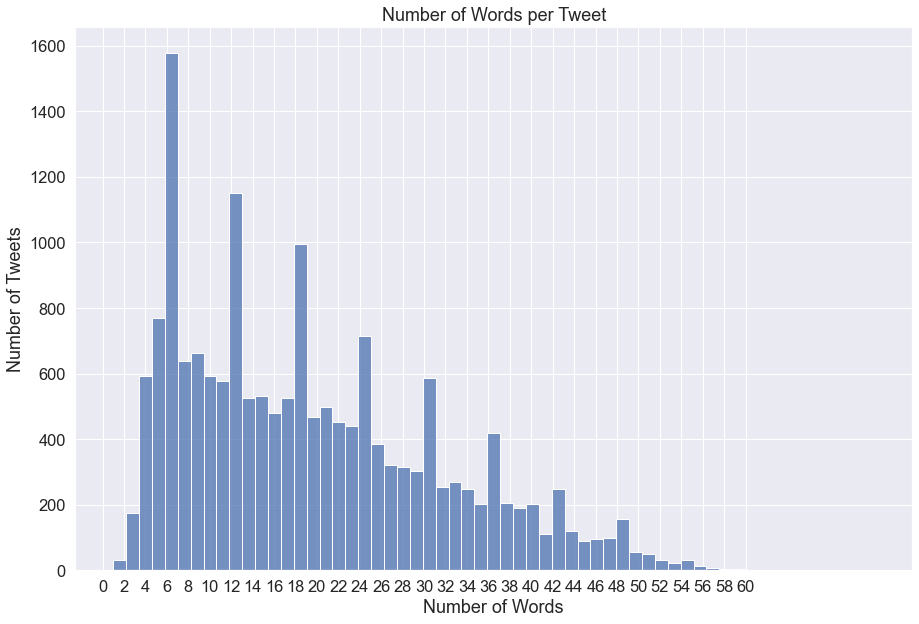

In [63]:
# let's look at the number of words per tweet again
sns.histplot(df.text.str.split().map(lambda words: len(words)), bins=59)
plt.xticks(list(range(0, 61, 2)))
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.title('Number of Words per Tweet');

In [64]:
# we are left with these tweets that have less than 3 words
df.loc[df.text.str.split().map(lambda words: len(words)) <= 3, 'text'].sample(20)

30969             bought with Tether 
9828       Sounds like indoctrination
12458     completely delusional tweet
25316         Fantastic and Beautiful
8964            Correction, 16K nodes
17742             should be difficult
26190            Eric is fantabulous!
21744        Herrfurthplatz in Berlin
20776             Saylor speaks facts
13287          She's absolutely right
13687             Miners are selling!
25920         Hamstercoin big project
11442            *shitcoin mastercard
14023     Misrepresenting the message
31650              Leverage.   Me too
26237            OMG, strange project
6114       LoooooooooooooooooooooooL 
31758      Leverage.   Everyday crash
20304        Speculators buy Bitcoin.
5692           Run by communists!!!!!
Name: text, dtype: object

###### Alright, it seems like we filtered out most of the spams. Let's continue

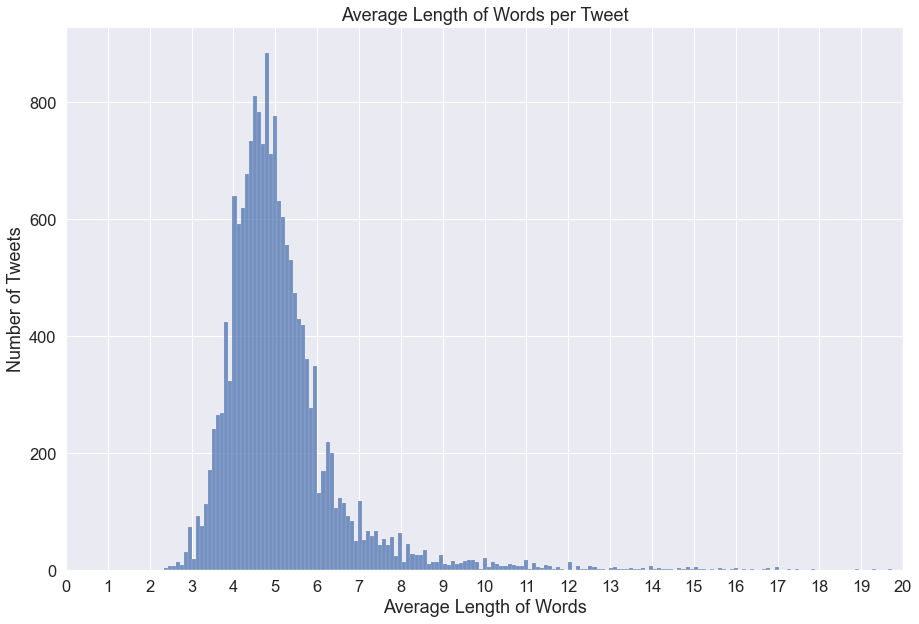

In [65]:
# let's check what is the average word length per tweet
sns.histplot(df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)))
plt.xticks(list(range(0, 30, 1)))
plt.xlim(0, 20)
plt.xlabel('Average Length of Words')
plt.ylabel('Number of Tweets')
plt.title('Average Length of Words per Tweet');

###### Let's take a closer look at the outliers

In [66]:
# tweets where average word length is more than 15
print('Aprox number of outliers is', df.loc[df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)) > 8, 'text'].__len__())
df.loc[df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)) > 15, 'text'].sample(10)

Aprox number of outliers is 759


33840     let us invest together and party together :co...
5653      :rolling_on_the_floor_laughing::rolling_on_th...
25335     It s in Austin! :clapping_hands::clapping_han...
21302     And your a fudder who bought BTC in HIGH and ...
13501     SHIB DroverToken droverinu BabyDogeCoin babyd...
13432     SHIB DroverToken droverinu BabyDogeCoin babyd...
6872      This adoption generate 150 new jobs in El Sal...
22197     Thank me later :backhand_index_pointing_down:...
33660     SpamBot YouGullibleAF KeepFailingWithEveryTwe...
22908     400 million free baby doge :backhand_index_po...
Name: text, dtype: object

In [67]:
# tweets where average word length is less than 2.8
df.loc[df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)) < 2.8, 'text'].sample(10)

19112                                Sorry I m not a moron
4571                                  I don t see why not!
13227                                what can I do for you
24184                        10 or 15? haha try 100 or 150
32303                    Lol oh no, no idea why I did that
12759                           WE KNOW !!! 6 K IS COMING 
15367                 There is no way you re up on xrp lol
33059                             Isn t it 1-3am in US? Gm
20449                                I will buy in 4 years
6549      O que vc n o entende vc n o comenta t pra n o...
Name: text, dtype: object

###### We can see that tweets with low average word length are fine for now. However, for tweets that have high average length, such behaviour is caused by demojizing emoji which does not create space in between the translated text. So we have to note that after demojizing we should split the translated text.

In [68]:
# NOTE: this is not the best regex since we will be creating spaces only between two emojis, but not an emoji and another word
df['text'].replace(r'::', ': :', regex=True, inplace=True)

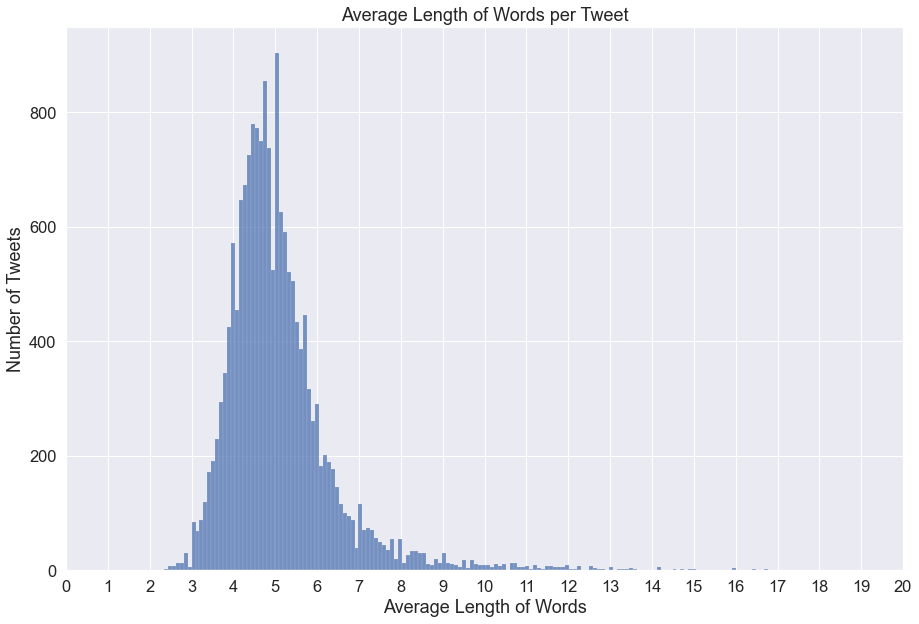

In [69]:
# now let's look at the distribution again
sns.histplot(df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)))
plt.xticks(list(range(0, 30, 1)))
plt.xlim(0, 20)
plt.xlabel('Average Length of Words')
plt.ylabel('Number of Tweets')
plt.title('Average Length of Words per Tweet');

In [70]:
print('Aprox number of outliers is', df.loc[df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)) > 8, 'text'].__len__())
df.loc[df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)) > 15, 'text']

Aprox number of outliers is 598


4226     float i,s,e;for(vec3 p,q,d=vec3((FC.xy-.5*r)/r...
5537      Founder of bitcoin is 000000000019d6689c085ae...
5653      :rolling_on_the_floor_laughing: :rolling_on_t...
6114                            LoooooooooooooooooooooooL 
7390      Of course it's not true:rolling_on_the_floor_...
7938      Hows that working out?:rolling_on_the_floor_l...
15324     metaxlauncher NFT NFTs :smiling_face_with_hea...
15830     Dogecoin TO THE MOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
21698     Satoshi is a cheater..:face_with_tears_of_joy...
22197     Thank me later :backhand_index_pointing_down:...
22827     Join chat:speech_balloon: to start earn:backh...
24446                                  goldensparrowtoken 
25630     I. Am. Gasping. :rolling_on_the_floor_laughin...
27221     Hahahhahahhahahahahahha fuck you all XRP hate...
27488     JeremyVine JurassicWorldDominion APCPresident...
29538     :red_exclamation_mark: :red_exclamation_mark:...
30655     "Nice" f*cking scammer :rolling_on_the_floor_.

In [71]:
df = df[~(df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)) > 15)]

###### Great, we cut the number of outliers by more than 20%. We are left with small number of tweets that still exceed 15 chars per word. They look spamy to me so will get rid such in our pipeline as well.

#### Our dataframe looks much cleaner now! Let's visualize most common words and ngrams!

In [72]:
stopwords = nltk.corpus.stopwords.words('english')
def get_corpus(dataframe):
    text = dataframe['text'].str.split().values.tolist()
    return [word for row in text for word in row]
corpus = get_corpus(df)

In [73]:
def plot_stop_words(corp):
    stop_words = defaultdict(int)
    for word in corp:
        if word.lower() in stopwords:
            stop_words[word] += 1
    stop_words_sorted = sorted(stop_words.items(), key=lambda item: item[1], reverse=True)[:20]
    sns.barplot(x='index', y=1, data=pd.DataFrame({k: v for k, v in stop_words_sorted}, index=[1]).T.reset_index())
    plt.title('Most Common Stop Words')
    plt.ylabel('Count')
    plt.xlabel('Stop Words')
    plt.show()

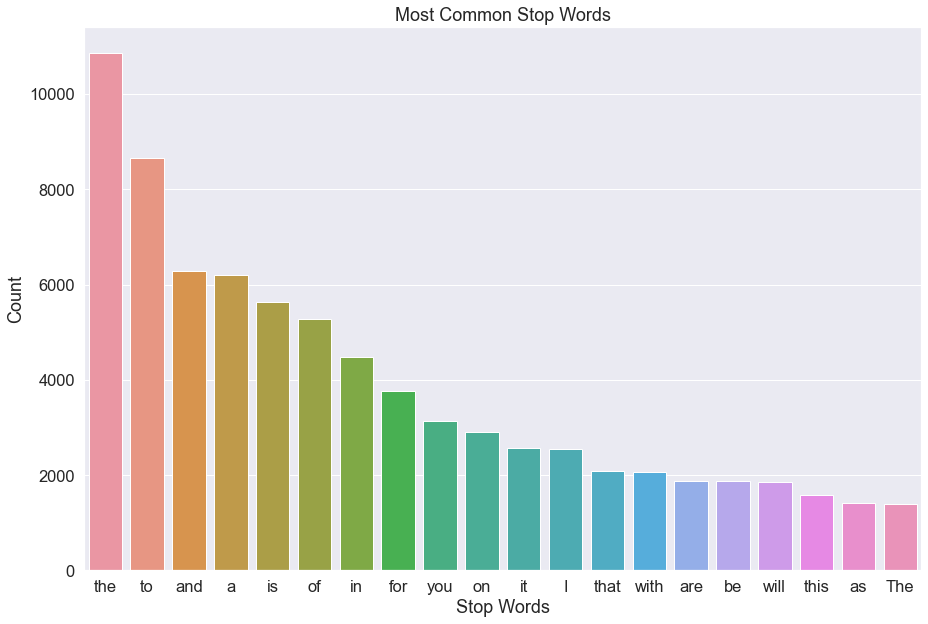

In [74]:
plot_stop_words(corpus)

In [75]:
# now lets plot most common non stopwords
def plot_most_common_words(corp, slice_=slice(0, 20)):
    counter = Counter(corp)
    most_common_words = counter.most_common()
    most_common_words = [(word, count) for word, count in most_common_words if word.lower() not in stopwords]
    sns.barplot(y='index', x=1, data=pd.DataFrame({word: count for word, count in most_common_words[slice_]}, index=[1]).T.reset_index(), orient='h')
    plt.title('Most Common Words')
    plt.ylabel('Words')
    plt.xlabel('Count')
    # plt.xticks(list(range(0, 2500, 200)))
    plt.show()
    return most_common_words

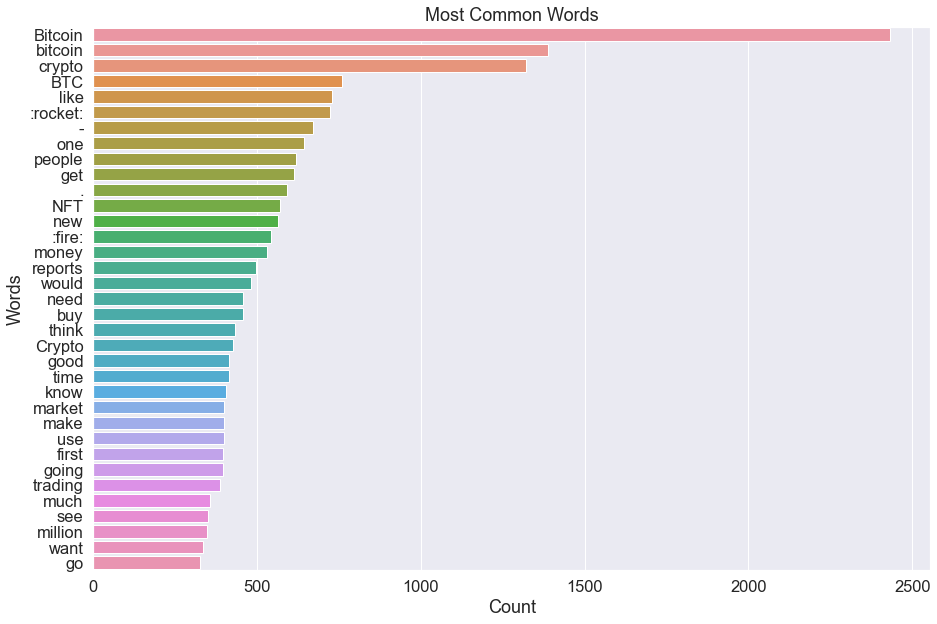

In [76]:
mcw = plot_most_common_words(corpus, slice(0, 35))

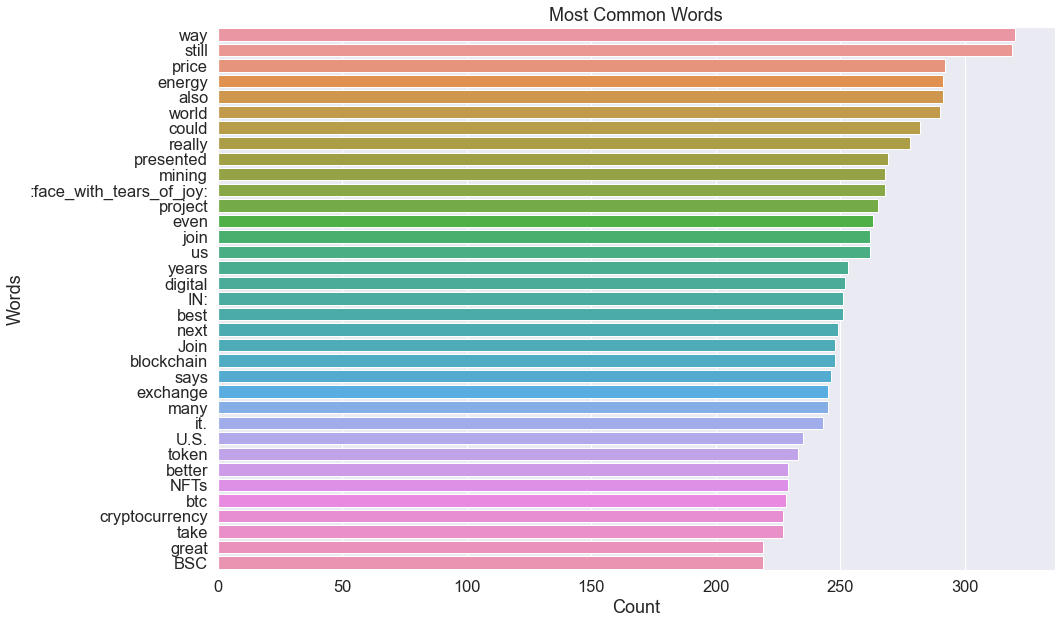

In [77]:
mcw = plot_most_common_words(corpus, slice(35, 70))

###### Great, we clearly can see that most common topic is btc. Also, we need to do some cleaning for '.', we will leave hyphen as it is.

In [78]:
def n_grammer(corp, n=2, most_common=10, title='Biagram'):
    vec = CountVectorizer(ngram_range=(n, n))
    bag_of_words = vec.fit_transform(corp)
    sum_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    word_freq =  sorted(word_freq, key=lambda item: item[1], reverse=True)[:most_common]
    word_freq = {k: v for k, v in word_freq}
    sns.barplot(y='index', x=1, data=pd.DataFrame(word_freq, index=[1]).T.reset_index(), orient='h')
    plt.title(title)
    plt.ylabel('Combinations')
    plt.xlabel('Count')
    plt.show()

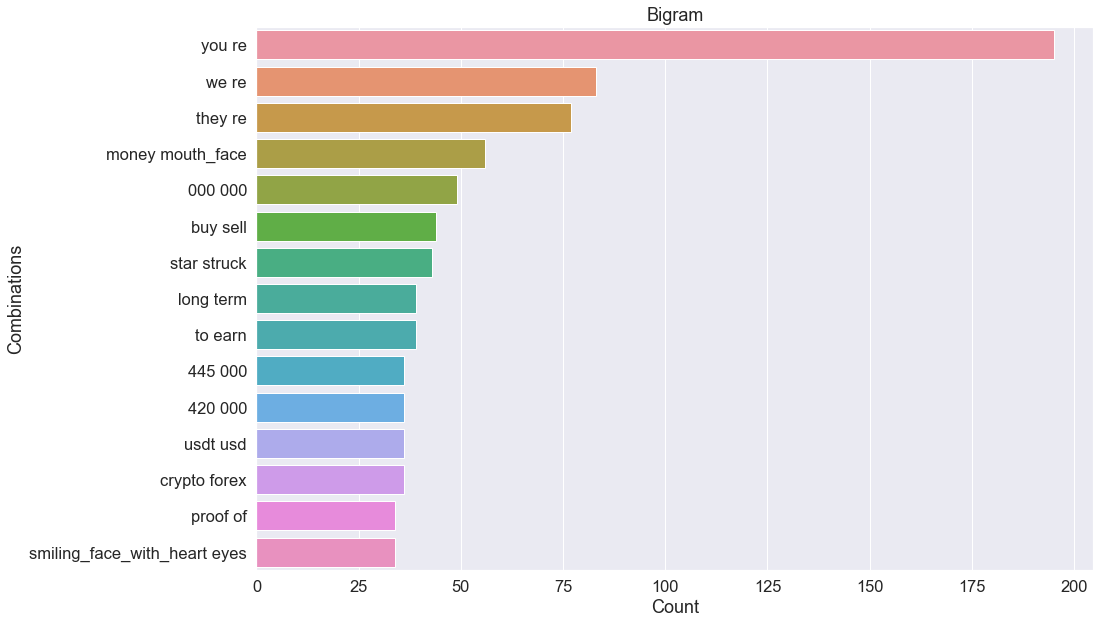

In [79]:
n_grammer(corpus, n=2, most_common=15, title='Bigram')

###### We probably want to connect numbers with underscore, and we want to correct "you re" to "you are" etc.

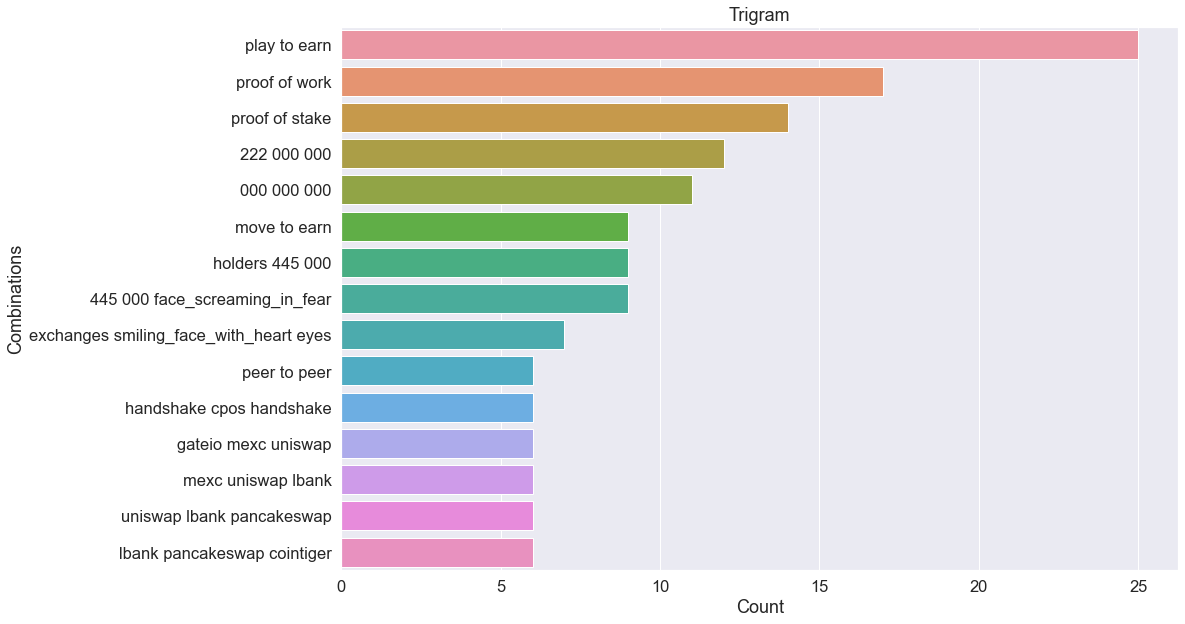

In [80]:
n_grammer(corpus, n=3, most_common=15, title='Trigram')

###### Beside connecting numbers with underscore, we want to check some of these phrases to make sure they are not spam

In [93]:
# let's clean up some of the mess that we found here
def preprocess_tweets(row):
    row = str(row)
    row = re.sub(r'\s+', ' ', row)
    row = row.replace('you re', 'you are').replace('we re', 'we are').replace('they re', 'they are').replace("'re", 'are').replace("I'm", "I am").replace('I m', 'I am').replace("i'm", 'I am').replace("can't", 'can not').replace('cannot', 'can not').replace("n't", ' not').replace("'ve", ' have').replace("'s", ' is').replace('you ll', 'you will').replace('we ll', 'we will').replace(' .', '.')

    row = row.replace('$', ' dollar ').replace('€', 'euro').replace('bitcoin', 'Bitcoin').replace('BTC', 'Bitcoin').replace('btc', 'Bitcoin').replace('Btc', 'Bitcoin').replace('Crypto', 'cryptocurrency').replace('cryptocurrencycurrency', 'cryptocurrency')
    row = re.sub(r'\s+', ' ', row)
    row = re.sub('(?<=\d) (?=\d)', '', row)
    # .replace(r'[0-9]\s000')
    return row

In [94]:
df.loc[:, 'text'] = df.text.apply(preprocess_tweets)

In [95]:
corpus1 = get_corpus(df)

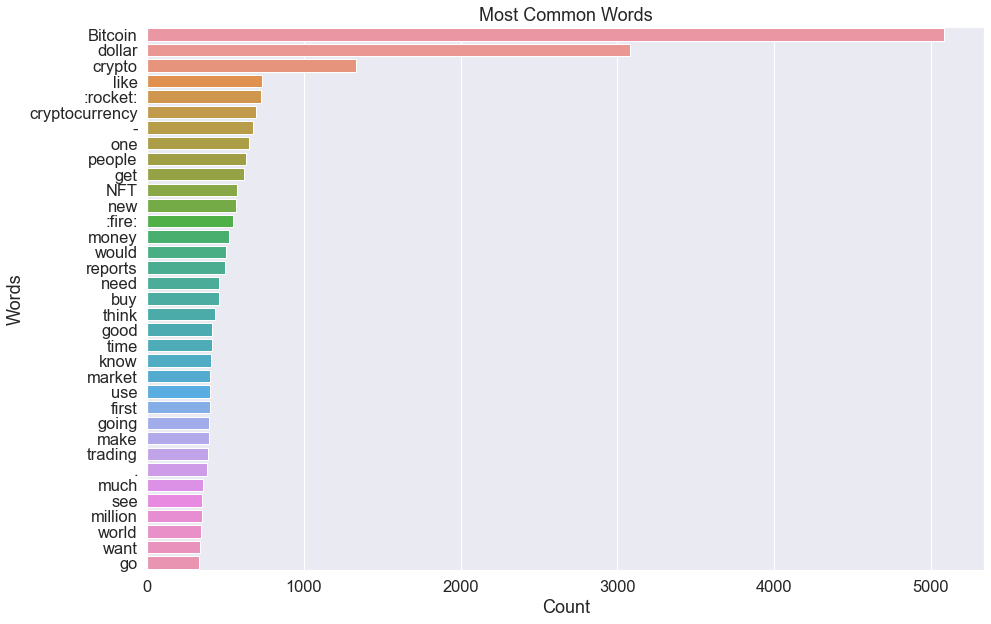

In [96]:
mcw = plot_most_common_words(corpus1, slice(35))

In [97]:
print(mcw[:100])

[('Bitcoin', 5088), ('dollar', 3083), ('crypto', 1335), ('like', 729), (':rocket:', 724), ('cryptocurrency', 696), ('-', 673), ('one', 646), ('people', 627), ('get', 616), ('NFT', 571), ('new', 563), (':fire:', 545), ('money', 522), ('would', 502), ('reports', 498), ('need', 457), ('buy', 456), ('think', 432), ('good', 414), ('time', 412), ('know', 406), ('market', 403), ('use', 398), ('first', 397), ('going', 395), ('make', 393), ('trading', 389), ('.', 382), ('much', 357), ('see', 350), ('million', 347), ('world', 341), ('want', 335), ('go', 327), ('way', 320), ('still', 319), ('could', 295), ('price', 292), ('also', 291), ('energy', 290), ('mining', 269), ('presented', 269), (':face_with_tears_of_joy:', 268), ('project', 267), ('1', 263), ('even', 262), ('join', 262), ('us', 262), ('really', 256), ('years', 253), ('digital', 252), ('IN:', 251), ('best', 251), ('next', 249), ('exchange', 249), ('Join', 248), ('blockchain', 248), ('says', 246), ('many', 245), ('it.', 245), ('U.S.', 23

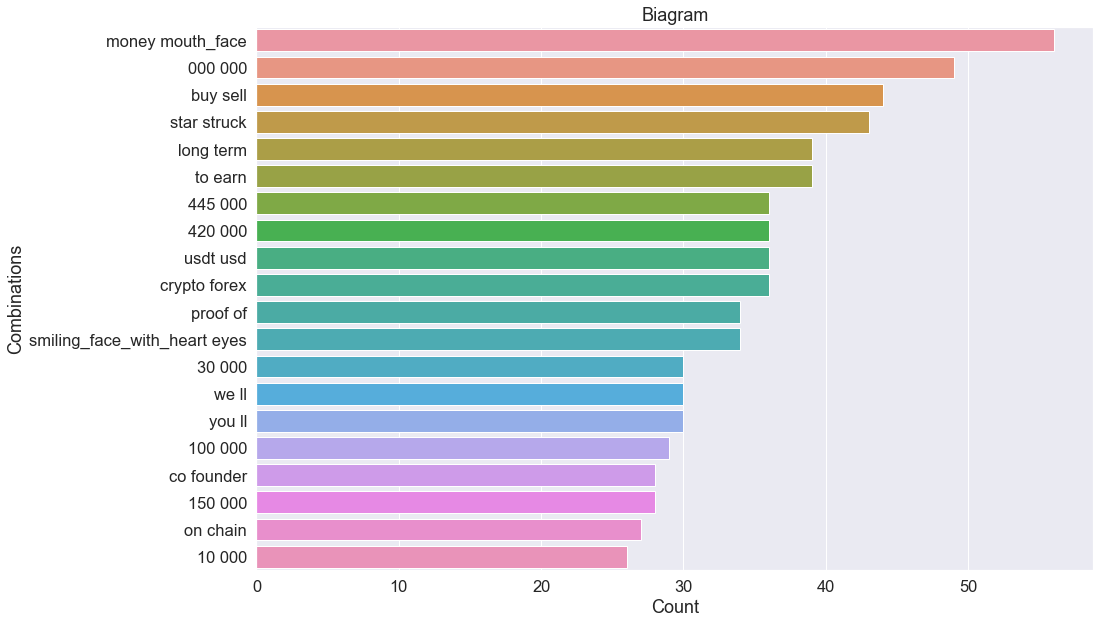

In [98]:
n_grammer(corpus1, 2, 20)

In [99]:
stop_words = set(STOPWORDS)
def plot_wordlcloud(corp):
    word_cloud = WordCloud(background_color='white', stopwords=stopwords, max_words=100, max_font_size=30, scale=3, random_state=4)
    word_cloud = word_cloud.generate(str(corp))
    plt.axis('off')
    plt.imshow(word_cloud)
    plt.show()

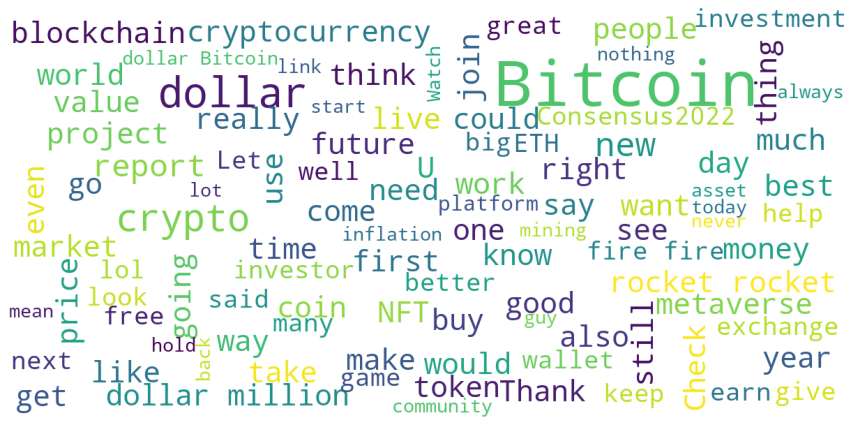

In [100]:
plot_wordlcloud(' '.join(corpus1))